# Packages

In [1]:
#%%capture
#!pip install wget
#!pip install wandb
#!pip install plot_keras_history
#!jupyter nbextension enable --py widgetsnbextension
#!pip install plot_keras_history

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
!mkdir saved_images

In [7]:
import pandas as pd
import cv2
import wget
import shutil
from tensorflow.keras.applications import VGG16
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import re
import json
import numpy as np
from plot_keras_history import show_history, plot_history


import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import random
from wandb.keras import WandbCallback
import wandb
import time
from keras import backend as K


In [8]:
#!

In [15]:
DATA_DIR = "/home/parker/data/WSDM2023/" # change to /content/ if running on GG COLAB
VISUALIZATION = False  
BATCH_SIZE = 8              
NUM_EPOCHS = 100           
EMBEDIND_SIZE = 256     
WORD_EMBEDING_SIZE = 32                        
LEARNING_RATE = 0.001         
MODEL = "VQA"                      
IMAGE_SIZE = 480
LOSS = "MSLE"
RNN_HIDDEN_SIZE = 128
ATT_EMBEDDING_SIZE = 256

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [25]:
TEST_TRAINING  = False
WANDB_LOG = True

# Data Loader

In [26]:
os.system(f'wget -P {DATA_DIR} https://github.com/Toloka/WSDMCup2023/raw/main/train.csv')

--2022-11-29 12:04:04--  https://github.com/Toloka/WSDMCup2023/raw/main/train.csv
Resolving github.com (github.com)... 20.248.137.48
Connecting to github.com (github.com)|20.248.137.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Toloka/WSDMCup2023/main/train.csv [following]
--2022-11-29 12:04:04--  https://raw.githubusercontent.com/Toloka/WSDMCup2023/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4808783 (4.6M) [text/plain]
Saving to: '/home/parker/data/WSDM2023/train.csv.1’

     0K .......... .......... .......... .......... ..........  1% 2.23M 2s
    50K .......... .......... .......... .......... ..........  2% 2.55M 2s
   100K .......... .......... .......... .........

0

In [27]:
train = pd.read_csv(DATA_DIR  + 'train.csv')
TRAIN_IMGS_DIR = DATA_DIR + "train_imgs/"
if TEST_TRAINING:
    train = train[:5000]

In [28]:
# Download data
try:
    os.mkdir(TRAIN_IMGS_DIR)
    img_paths = Parallel(
    n_jobs=100)(delayed(wget.download)(img_url, out= TRAIN_IMGS_DIR) for img_url in tqdm(train.image)
    )
except:
    print("the training set has been downloaded")

the training set has been downloaded


In [29]:
#Get the image path from URL
train.image  = train.image.apply(lambda x: str(x.split("/")[-1]))
train.image  = train.image.apply(lambda x: TRAIN_IMGS_DIR + str(x))

In [30]:
#Spit the original training set into 2 dataframes
train_sample = int(len(train)*0.8)
df_train = train[:int(len(train)*0.8)]
df_val = train[int(len(train)*0.8):]

df_train = df_train.reset_index(drop =True)
df_val = df_val.reset_index(drop =True)

if TEST_TRAINING:
    df_train = df_train[:10*BATCH_SIZE]
    df_val =  df_val[:10*BATCH_SIZE]

## Image Processing

In [13]:
%pylab inline
from concurrent.futures import process


def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    cols, rows,*_ = x.shape
    Y = np.zeros((cols, rows))
    bb = bb.astype(np.int64)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    rows , cols = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int64)

def xyxy2xywh(box): #Convert box format [xmin ymin xmax ymax] --> [x center, y center, width, height] and normalize the box
    xmin, ymin, xmax, ymax = box
    w = xmax - xmin         # Width of the box
    h = ymax - ymin         # Height of the box
    x_center = (xmin + (w/2))/IMAGE_SIZE 
    y_center = (ymin + (h/2))/IMAGE_SIZE 
    new_w = w/ IMAGE_SIZE 
    new_h = h/IMAGE_SIZE
    return np.array([x_center,y_center, new_w, new_h], dtype=np.float32)

def resize_image_bb(img_path,bb,sz, question, show_example):
    """Resize an image and its bounding box and write image to new path"""
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    mask = create_mask(bb, img)
    if show_example:
        result = img.copy()
        cv2.rectangle(result, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 5)
        plt.figure()
        plt.title("Original Image")
        plt.xlabel(f"{question} \n bb: {bb}")
        plt.imshow(result)
        plt.show
    
    img_resized = cv2.resize(img, (sz, sz))
    mask_resized = cv2.resize(mask, (sz, sz))
    bb_resized = mask_to_bb(mask_resized)
    x_center,y_center, new_w, new_h = xyxy2xywh(bb_resized)
    processed_box = np.array([x_center,y_center, new_w, new_h], dtype=np.float32)
    if show_example:

        new_result = img_resized.copy()
        cv2.rectangle(new_result, (bb_resized[0], bb_resized[1]), (bb_resized[2], bb_resized[3]), (0, 255, 0), 5)
        plt.figure()
        plt.title("Resized Image")
        plt.imshow(new_result)
        plt.xlabel(f"{question} \n bb: {bb_resized} \n processed_box: {processed_box}")
        plt.show
    return np.array(img_resized, dtype = np.float32), bb_resized, processed_box



def xywh2xyxy(box): #Convert box format [x center, y center, width, height]  --> [xmin ymin xmax ymax] and normalize the box
    x_center,y_center, new_w, new_h = box*IMAGE_SIZE
    xmin = x_center - (new_w/2)
    ymin = y_center - (new_h/2)
    xmax = x_center + (new_w/2)
    ymax = y_center + (new_h/2)
    return np.array([xmin, ymin, xmax, ymax], dtype=np.int64)

def image_box_processing(image_path, box, question = None, show_example = True):
        img_resized, bb_resized , processed_box = resize_image_bb(image_path, box,IMAGE_SIZE, question, show_example)
        return img_resized, bb_resized, processed_box

Populating the interactive namespace from numpy and matplotlib


/home/ngoc/anaconda3/envs/tf/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Question Processing

In [14]:
class Text_Dict:

    """Aim to convert index to word or word to index"""

    def __init__(self, vocab):
        
        self.word_list = vocab
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(f'word {w} not in dictionary (while dictionary does not contain <unk>)')

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds

## Data Pipeline Loaders

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, question_vocab, batch_size=32):
        'Initialization'
        self.dataset = dataset
        self.batch_size = batch_size
        self.question_vocab = question_vocab
        self.question_dict = Text_Dict(self.question_vocab)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))


    def make_vocab_questions(self, questions):
        """Make dictionary for questions and save them into text file."""

        print("- Creating a vocab list for questions")
        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []

        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '')
        vocab_list.insert(1, '')
        print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
        print(f'    + Maximum length of question: {np.max(question_length)}')
        return vocab_list


    def tokenize(self, sentence):

        """Split string lines into lists"""
        
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
        tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
        return tokens

    def question_processing(self, question):
        question_token = self.tokenize(question)
        question_2_idx = [self.question_dict.word2idx(w) for w in question_token ]
        return  question_2_idx
    


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.dataset.iloc[k] for k in indexes]
        images, questions, boxes = self.__data_generation(batch_data)
        return [{
            'input_image': np.array(images, dtype =np.float32),
            'input_question': np.array(questions, dtype =int)},
            np.array(boxes, dtype =np.float32)]

    def __data_generation(self, batch_data):
        images = []
        questions = []
        boxes = []
        question_len = []
        for image_path, width, hieght, left, top, right, bottom, question in batch_data:
            box = np.array([left, top, right, bottom],dtype = np.float32)
            resized_image, resized_box, processed_box = image_box_processing(image_path, box, question = None, show_example = False)

            question = self.question_processing(question)
            question_len.append(len(question))

            questions.append(question)
            boxes.append(processed_box)
            images.append(resized_image/225)
        questions = pad_sequences(questions, maxlen = max(question_len), dtype='float32', value=0, padding='pre')
        return images, questions, boxes


In [16]:
def make_vocab_questions(questions):
        """Make dictionary for questions and save them into text file."""

        print("- Creating a vocab list for questions")
        vocab_set = set()
        SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
        question_length = []

        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question.lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

        vocab_list = list(vocab_set)
        vocab_list.sort()
        vocab_list.insert(0, '')
        vocab_list.insert(1, '')
        print(f'    + The size of Question vocabbulary {len(vocab_list)}.')
        print(f'    + Maximum length of question: {np.max(question_length)}')
        return vocab_list

In [17]:
question_vocab = make_vocab_questions(train["question"])

- Creating a vocab list for questions
    + The size of Question vocabbulary 7494.
    + Maximum length of question: 41


# Model

In [18]:
def iou(y_true, y_pred, xyxy = False):
    # iou as metric for bounding box regression
    
    if not xyxy:
        # convert input to be as [x1, y1, x2, y2]
        y_true = y_true*IMAGE_SIZE
        y_true_xmin, y_true_ymin  = y_true[:,0] - y_true[:,2]/2, y_true[:,1] - y_true[:,3]/2
        y_true_xmax, y_true_ymax  = y_true[:,0] + y_true[:,2]/2, y_true[:,1] + y_true[:,3]/2
        y_true = tf.stack([y_true_xmin, y_true_ymin, y_true_xmax, y_true_ymax], 1)
    
        # convert predictions to be as [x1, y1, x2, y2]
        y_pred = y_pred*IMAGE_SIZE
        y_pred_xmin, y_pred_ymin  = y_pred[:,0] - y_pred[:,2]/2, y_pred[:,1] - y_pred[:,3]/2
        y_pred_xmax, y_pred_ymax  = y_pred[:,0] + y_pred[:,2]/2, y_pred[:,1] + y_pred[:,3]/2
        y_pred = tf.stack([y_pred_xmin, y_pred_ymin, y_pred_xmax, y_pred_ymax], 1)
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou

In [19]:
def save_prediction(img, img_dix, pred_bb, gt_bb, question, epoch, mode, xyxy = False):
    cv2.imwrite(f'./saved_images/{mode}_img_{img_dix}.jpg', img)
    img = cv2.cvtColor(cv2.imread(f'./saved_images/{mode}_img_{img_dix}.jpg'), cv2.COLOR_BGR2RGB)
    result = img.copy()
    cv2.rectangle(result, (int(gt_bb[0]), int(gt_bb[1])), (int(gt_bb[2]), int(gt_bb[3])), (0, 255, 0), 3)
    cv2.rectangle(result, (int(pred_bb[0]), int(pred_bb[1])), (int(pred_bb[2]), int(pred_bb[3])), (255, 0, 0), 3)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(question)
    plt.savefig(f"./saved_images/{mode}_img_{img_dix}_epoch_{epoch}.jpg")
    plt.close()

In [20]:
columns=["epoch", "dataset", "image", "iou"]
train_table = wandb.Table(columns=columns)
val_table = wandb.Table(columns=columns)
class Log_Img_Callback(keras.callbacks.Callback):
    
    #SAVE PREDICTIONS ON WANDB
    def __init__(self, train_generator,val_generator):
        super().__init__()
        self.train_samples = train_generator[0]
        self.val_samples = val_generator[0]
        self.train_generator = train_generator
        
    def iou(self, box_predicted, box_truth):
        # get (x, y) coordinates of intersection of bounding boxes
        top_x_intersect = max(box_predicted[0], box_truth[0])
        top_y_intersect = max(box_predicted[1], box_truth[1])
        bottom_x_intersect = min(box_predicted[2], box_truth[2])
        bottom_y_intersect = min(box_predicted[3], box_truth[3])

        # calculate area of the intersection bb (bounding box)
        intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
            0, bottom_y_intersect - top_y_intersect + 1
        )

        # calculate area of the prediction bb and ground-truth bb
        box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
            box_predicted[3] - box_predicted[1] + 1
        )
        box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
            box_truth[3] - box_truth[1] + 1
        )

        # calculate intersection over union by taking intersection
        # area and dividing it by the sum of predicted bb and ground truth
        # bb areas subtracted by  the interesection area

        # return ioU
        return intersection_area / float(
            box_predicted_area + box_truth_area - intersection_area
        )
    
    def xywh_to_xyxy(self, bboxes):
        bboxes = bboxes*IMAGE_SIZE
        bboxes[:,0], bboxes[:,2] = bboxes[:,0] - bboxes[:,2]/2,bboxes[:,0] + bboxes[:,2]/2
        bboxes[:,1], bboxes[:,3] = bboxes[:,1] - bboxes[:,3]/2, bboxes[:,1] + bboxes[:,3]/2
        return bboxes
        

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 20 == 0:
            train_input, train_output = self.train_samples
            train_predictions = self.model.predict(train_input, verbose = 0)
            train_predictions =self.xywh_to_xyxy(train_predictions)
            train_output = self.xywh_to_xyxy(train_output)
            for i in range(len(train_predictions)):
                iou = self.iou(train_predictions[i], train_output[i])
                img = train_input["input_image"][i]*225
                text = ""
                for idx in train_input["input_question"][i]:
                    text += self.train_generator.question_dict.idx2word(idx)
                    text += " "
                save_prediction(img, i, train_predictions[i], train_output[i], text, epoch+1, "train")
                train_table.add_data(epoch+1, "train", wandb.Image(f"./saved_images/train_img_{i}_epoch_{epoch+1}.jpg"), iou)
            
            val_input, val_output = self.val_samples
            val_predictions = self.model.predict(val_input, verbose = 0)
            val_predictions =self.xywh_to_xyxy(val_predictions)
            val_output = self.xywh_to_xyxy(val_output)
            for i in range(len(val_predictions)):
                iou = self.iou(val_predictions[i], val_output[i])
                img = val_input["input_image"][i]*225
                text = ""
                for idx in val_input["input_question"][i]:
                    text += self.train_generator.question_dict.idx2word(idx)
                    text += " "
                save_prediction(img, i, val_predictions[i], val_output[i], text, epoch+1, "val")
                val_table.add_data(epoch+1, "val", wandb.Image(f"./saved_images/val_img_{i}_epoch_{epoch+1}.jpg"), iou)

In [21]:
class ImageEncoder(tf.keras.layers.Layer):
    def __init__(self, embedding_size, img_size):
        super(ImageEncoder, self).__init__()
        # Define VGG 16
        self.vgg_net = VGG16(weights='imagenet',include_top=False, input_shape=(img_size, img_size, 3))
        self.vgg_net.trainable = False
        self.dense = layers.Dense(embedding_size, activation = "relu")
    
    def call(self, images):
        # batch*img_size*img_size*3
        image_tensor = tf.convert_to_tensor(images)

        # batch*20*20*512
        image_feature = self.vgg_net(image_tensor)

        # batch*400*512
        #image_feature = layers.Flatten()(image_feature)
        image_feature = tf.reshape(image_feature , [-1,image_feature.shape[2]*image_feature.shape[1] , image_feature.shape[3]])
        
        # batch*400*embedding_size

        image_feature = self.dense(image_feature)
        return image_feature

In [22]:
class QuestionEncoder(tf.keras.layers.Layer):
    def __init__(self, question_vocab_size, question_embedding_size, embedding_size, rnn_hidden_size):
        super(QuestionEncoder, self).__init__()
        self.embedding_size = embedding_size
        self.rnn_hidden_size = rnn_hidden_size

        #Define Question Embeding
        self.word2vec  = layers.Embedding(input_dim=question_vocab_size, output_dim = question_embedding_size)

        # Define LSTM
        self.lstm = tf.keras.layers.LSTM(rnn_hidden_size)

        #Define dense output layer
        self.dense = layers.Dense(embedding_size, activation = "tanh")

    def call(self, questions):
        # batch*question_len

        question_tensor = tf.convert_to_tensor(questions)

        # batch*question_len*question_embedding_size
        question_vec = self.word2vec(question_tensor)
        
        # batch*rnn_hidden_size
        question_feature  =  self.lstm(question_vec)
        
        question_feature = self.dense(question_feature)
        return question_feature

In [23]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super().__init__()
        self.image_feature_convert = layers.Dense(output_dim, activation = 'tanh')
        self.question_feature_convert = layers.Dense(output_dim, activation = 'tanh')
    def call(self, image_features, question_features):
        #batch*400*embedding_size
        hi = self.image_feature_convert(image_features)
        #batch*embedding_size
        hq = self.question_feature_convert(question_features)
        #batch*1*embedding_size
        hq = tf.expand_dims(hq, axis = 1)

        #batch*400*embedding_size
        ha  = tf.tanh(hi + hq)
        ha = layers.Dropout(0.5)(ha)
        ha = layers.Dense(1)(ha)
        ha = tf.reshape(ha , [-1,ha.shape[1]])
        pi = tf.nn.softmax(ha)
        pi = tf.expand_dims(pi , axis = -1)
        att_layer = tf.reduce_sum(pi * image_features , axis = 1)
        u = att_layer + question_features
        return  u

In [24]:
class VQA(tf.keras.Model):
    def __init__(self, embedding_size, 
                img_size, 
                question_vocab_size, 
                question_embedding_size,
                rnn_hidden_size,
                atention_out_dim,
                num_att_layers):
        super().__init__()
        self.image_encoder = ImageEncoder(embedding_size, img_size)
        self.question_encoder = QuestionEncoder(
                                    question_vocab_size = question_vocab_size,
                                    question_embedding_size = question_embedding_size,
                                    embedding_size = embedding_size,
                                    rnn_hidden_size = rnn_hidden_size
                                )
        
        #self.attention = Attention(atention_out_dim)
        self.output_layer = layers.Dense(4, activation='sigmoid', name="output")
        self.Stacked_Attend = [Attention(output_dim=atention_out_dim)]* num_att_layers

    def call(self, data):

        images, questions = data["input_image"], data["input_question"]

        image_features = self.image_encoder(images)
        question_features = self.question_encoder(questions)
        u = question_features
        for attn_layer in self.Stacked_Attend:
            u = attn_layer(image_features, u)
        output = self.output_layer(u)
        return tf.convert_to_tensor(output)

In [25]:
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    elif epoch < 40:
        return lr/10
    elif epoch < 80:
        return lr/100
    elif epoch < 80:
        return lr/1000

# Traning

In [26]:
strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
with strategy.scope():
    #Data Generation
    train_generator = DataGenerator(df_train,question_vocab, BATCH_SIZE)
    val_generator = DataGenerator(df_val,question_vocab, BATCH_SIZE)
    
    vocab_size = train_generator.question_dict.vocab_size
    
    #Create VQA model
    VQA_model = VQA(
        embedding_size = EMBEDIND_SIZE,
        img_size=IMAGE_SIZE,
        question_embedding_size= WORD_EMBEDING_SIZE,
        question_vocab_size = train_generator.question_dict.vocab_size,
        rnn_hidden_size=RNN_HIDDEN_SIZE,
        atention_out_dim = ATT_EMBEDDING_SIZE,
        num_att_layers = 2
    
    )
    
    VQA_model.compile(keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics = [iou, 'mae', tf.keras.metrics.RootMeanSquaredError()])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_iou', patience=20) 
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    
    if WANDB_LOG:
        wandb_img_callback = Log_Img_Callback(train_generator, val_generator)
        wandb_loss_log = WandbCallback(monitor="val_iou", save_model=False)
        callbacks = [wandb_img_callback, wandb_loss_log, early_stop, lr_schedule]
    else:
        callbacks = [ lr_schedule]
        

    history = VQA_model.fit(
        train_generator,
        epochs=NUM_EPOCHS,
        callbacks = callbacks,
        verbose = 1,
        validation_data = val_generator,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100


/home/ngoc/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


3899/3899 [==============================] - 1748s 448ms/step - loss: 0.0170 - iou: 0.1203 - mae: 0.1404 - root_mean_squared_error: 0.1842 - val_loss: 0.0162 - val_iou: 0.1277 - val_mae: 0.1366 - val_root_mean_squared_error: 0.1809 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
3899/3899 [==============================] - 1747s 448ms/step - loss: 0.0155 - iou: 0.1241 - mae: 0.1330 - root_mean_squared_error: 0.1763 - val_loss: 0.0159 - val_iou: 0.1256 - val_mae: 0.1335 - val_root_mean_squared_error: 0.1789 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
3899/3899 [==============================] - 1747s 448ms/step - loss: 0.0149 - iou: 0.1268 - mae: 0.1297 - root_mean_squared_error: 0.1730 - val_loss: 0.0161 - val_iou: 0.1281 - val_mae: 0.1369 - val_root_mean_squared_error: 0.1793 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
E

(<Figure size 2000x1000 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
         <AxesSubplot:title={'center':'Iou'}, xlabel='Epochs', ylabel='Iou'>,
         <AxesSubplot:title={'center':'Mae'}, xlabel='Epochs', ylabel='Mae'>,
         <AxesSubplot:title={'center':'Root MSE'}, xlabel='Epochs', ylabel='Root MSE'>],
        [<AxesSubplot:title={'center':'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

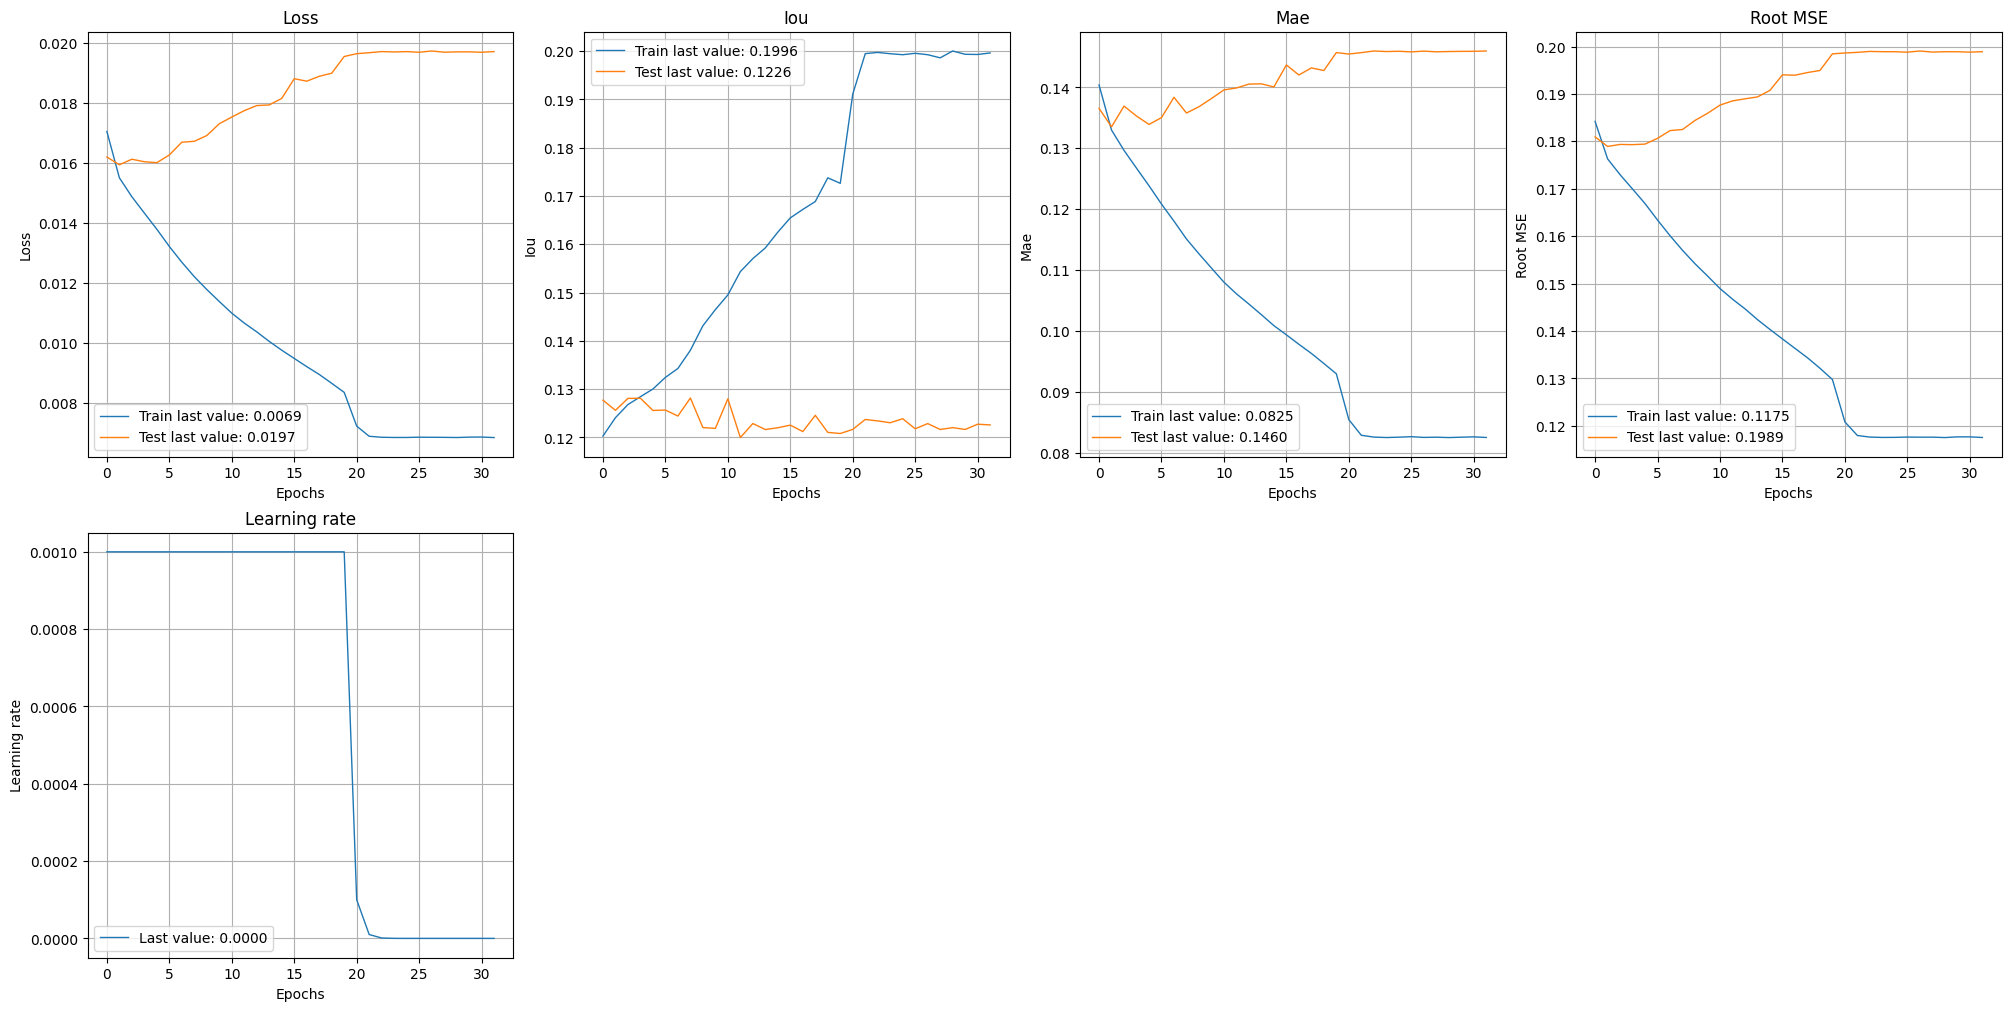

In [27]:
plot_history(history)

In [28]:
if WANDB_LOG:
    wandb.log({"train example": train_table})
    wandb.log({"val example": val_table})
    #os.system('rm -rf saved_images')
    wandb.finish()


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
iou,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▇███████████
loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,█▆██▆▆▅█▃▃█▁▃▂▃▃▂▅▂▂▂▄▄▄▄▃▃▂▃▂▃▃
val_loss,▁▁▁▁▁▂▂▂▃▄▄▄▅▅▅▆▆▆▇█████████████
val_mae,▃▁▃▂▁▂▄▂▃▄▄▅▅▅▅▇▆▆▆█████████████
val_root_mean_squared_error,▂▁▁▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇█████████████
best_epoch,11
best_val_iou,0.11999
